<a href="https://colab.research.google.com/github/MehmethanOzansoy/deep_learning/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RNN İle Havayolu Yolcu Sayısı Tahmini**

------------------------------------------------------







In [2]:

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import os 

os.environ['tf_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/AirPassengers.csv')

In [5]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
df.columns

Index(['Month', '#Passengers'], dtype='object')

In [7]:
df.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [8]:
df.isnull().sum()

Month          0
#Passengers    0
dtype: int64

In [9]:
df.shape

(144, 2)

In [10]:
df.dtypes

Month          object
#Passengers     int64
dtype: object

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
#Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


Yayılım fazla mean-std : std aslında sapmaların ortalamasıdır. Diğer değerler mean nin etradında nasıl toplanıyor ne kadar uzak .

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [14]:
df["Month"] = pd.to_datetime(df["Month"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [15]:
print("Minimum Tarih:", df["Month"].min())
print("Maksimum Tarih:", df["Month"].max())

Minimum Tarih: 1949-01-01 00:00:00
Maksimum Tarih: 1960-12-01 00:00:00


In [16]:
df.index= df["Month"]

In [17]:
df.head()

,Month,#Passengers
Month,,
1949-01-01,1949-01-01,112
1949-02-01,1949-02-01,118
1949-03-01,1949-03-01,132
1949-04-01,1949-04-01,129
1949-05-01,1949-05-01,121


In [18]:
df.drop("Month", axis=1, inplace=True)

In [19]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [20]:
result_df = df.copy()

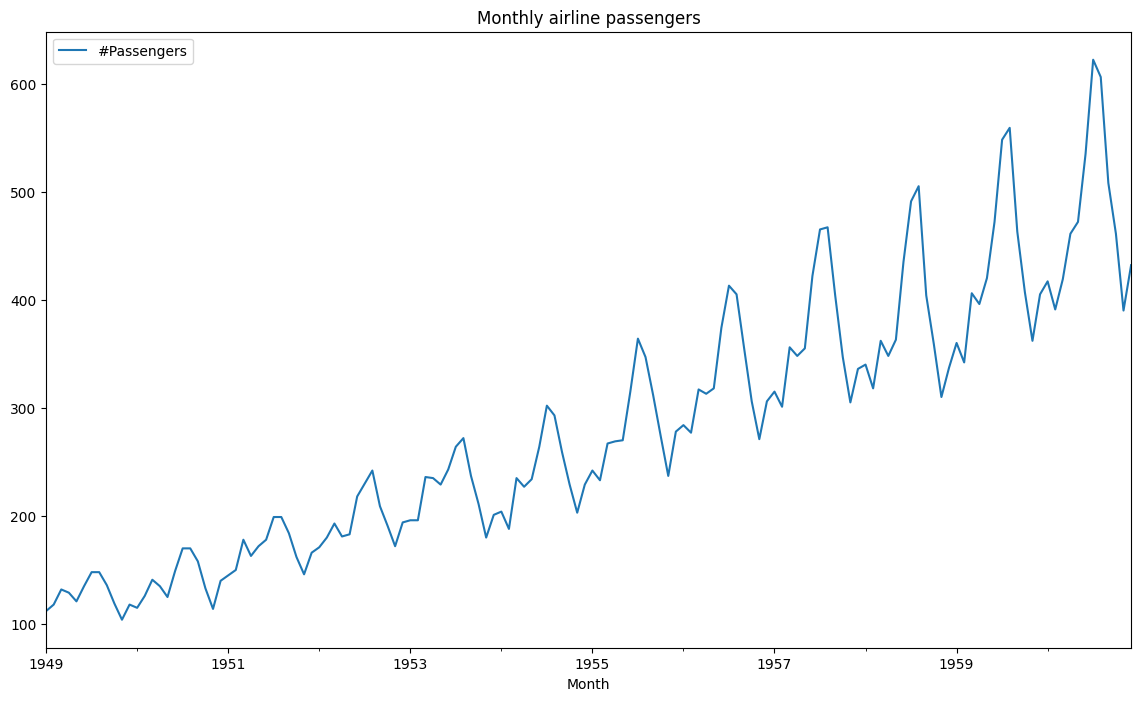

In [21]:
df.plot(figsize=(14,8), title="Monthly airline passengers");

In [26]:
df = df.rename(columns={'#Passengers':'Passengers'})

In [27]:
data = df["Passengers"].values

In [28]:
data[0:5]

array([112, 118, 132, 129, 121])

In [29]:
type(data[0:5])

numpy.ndarray

In [30]:
data = data.astype('float32')

In [31]:
type(data[0])

numpy.float32

In [32]:
data.shape

(144,)

In [33]:
data = data.reshape(-1,1)

In [34]:
data.shape

(144, 1)

In [40]:
def split_data(dataframe, test_size):
  '''
  Burada fonksiyonumuz kontrollü veriyi dağıtmadan bölme işleni yapmaktadır
  '''

  position = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]

  return train ,test , position

In [89]:
train, test, position = split_data(data, 0.33)

In [90]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [91]:
scaler_train = MinMaxScaler(feature_range=(0,1))

In [92]:
train = scaler_train.fit_transform(train)

In [93]:
scaler_test = MinMaxScaler(feature_range=(0,1))

In [94]:
test = scaler_test.fit_transform(test)

**Kısa Not**

```
fruits = [ 'banana', 'pineapple', 'guava' ]
 
capitalize_fruits = [ f.capitalize() for f in fruits ]
 
print(capitalize_fruits)

Output: 
['Banana', 'Pineapple', 'Guava']
```



In [95]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [96]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [97]:
def create_features(data, lookback):
  X,Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  
  return np.array(X), np.array(Y)

In [98]:
lookback = 1

In [99]:
X_train, y_train = create_features(train, lookback)

In [100]:
X_test, y_test = create_features(test, lookback)

In [101]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [102]:
##3 boyutlu yapıya çeviriyoruz => tensor
X_train = np.reshape(X_train, (X_train.shape[0], 1,X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1,X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [103]:
y_test

array([[0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433],
       [0.37694705],
       [0.51090336],
       [0.51713395],
       [0.3208723 ],
       [0.1433022 ],
       [0.01246107],
       [0.1090343 ],
       [0.12149537],
       [0.0529595 ],
       [0.19003117],
       [0.1464175 ],
       [0.19314647],
       [0.41744542],
       [0.59190035],
       [0.635514  ],
       [0.3208723 ],
       [0.1806854 ],
       [0.02803737],
       [0.11214948],
       [0.18380058],
       [0.12772584],
       [0.32710278],
       [0.29595017],
       [0.37071645],
       [0.5327103 ],
       [0.76947033],
       [0.80373836],
       [0.5046729 ],
       [0.33021808],
       [0.19003117],
       [0.32398748],
       [0.36137068],
       [0.2803738 ],
       [0.36760128],
       [0.4984424 ],
       [0.5327103 ],
       [0.72897196],
       [1.        ],
       [0.95015574],
       [0.6448598 ],
       [0.4984424 ],
       [0.27725852],
       [0.40809965]], dtype=float3

In [104]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


In [105]:
model = Sequential()

model.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [106]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________
None


**Optimisazyon ve Değerlendirme Metrikleri Ayarlanması**

---



In [107]:
model.compile(loss='mean_squared_error', optimizer ='rmsprop')

In [108]:
callbacks =[EarlyStopping(monitor='val_loss', patience = 3, verbose = 1, mode = 'min'),
            ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=1)]

In [109]:
history = model.fit(x = X_train,
                    y= y_train,
                    epochs =50,
                    batch_size = 1,
                    validation_data =(X_test, y_test),
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/50
94/95 [============================>.] - ETA: 0s - loss: 0.0118
Epoch 1: val_loss improved from inf to 0.02961, saving model to mymodel.h5
95/95 [==============================] - 2s 6ms/step - loss: 0.0118 - val_loss: 0.0296
Epoch 2/50
78/95 [=======================>......] - ETA: 0s - loss: 0.0125
Epoch 2: val_loss improved from 0.02961 to 0.02575, saving model to mymodel.h5
95/95 [==============================] - 0s 5ms/step - loss: 0.0147 - val_loss: 0.0258
Epoch 3/50
88/95 [==========================>...] - ETA: 0s - loss: 0.0088
Epoch 3: val_loss improved from 0.02575 to 0.02184, saving model to mymodel.h5
95/95 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0218
Epoch 4/50
91/95 [===========================>..] - ETA: 0s - loss: 0.0104
Epoch 4: val_loss did not improve from 0.02184
95/95 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0259
Epoch 5/50
77/95 [=======================>......] - ETA: 0s - loss: 0.00

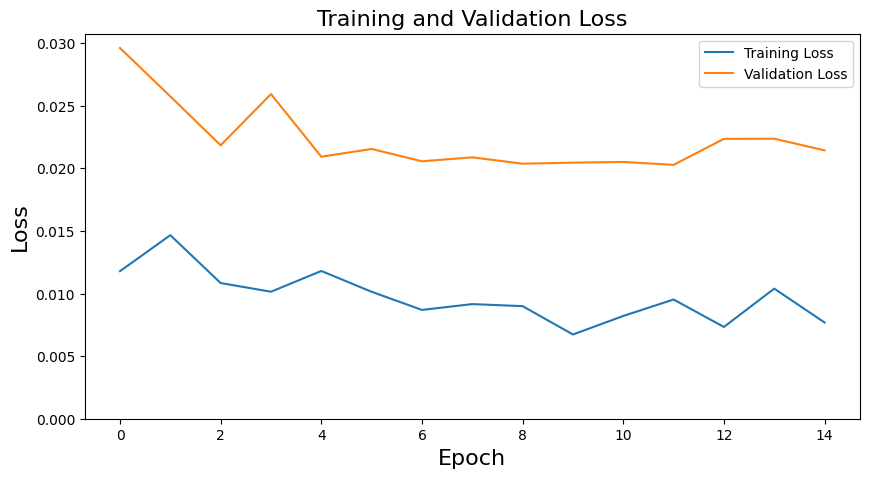

In [110]:
plt.figure(figsize=(22,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

**Model Evaluation**

In [111]:
loss = model.evaluate(X_test, y_test, batch_size=1)
print("\nTest loss: %.1f%%" % (100.0 * loss)) 

47/47 [==============================] - 0s 2ms/step - loss: 0.0214

Test loss: 2.1%


In [112]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 4ms/step


In [113]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [114]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [115]:
train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))

In [116]:
test_rmse = np.sqrt(mean_squared_error(y_test,test_predict))

In [117]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 23.79473304748535
Test RMSE: 47.00174331665039


In [118]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [119]:
train_prediction_df = result_df[lookback:position]
train_prediction_df["Predicted"] = train_predict
train_prediction_df.head()

,#Passengers,Predicted
Month,,
1949-02-01,118,132.121643
1949-03-01,132,135.209961
1949-04-01,129,144.820145
1949-05-01,121,142.469803
1949-06-01,135,136.850906


In [120]:
test_pred_df = result_df[position+lookback:]
test_pred_df["Predicted"] = test_predict
test_pred_df.head()

,#Passengers,Predicted
Month,,
1957-02-01,301,333.130432
1957-03-01,356,327.254517
1957-04-01,348,368.123474
1957-05-01,355,360.455200
1957-06-01,422,367.164978


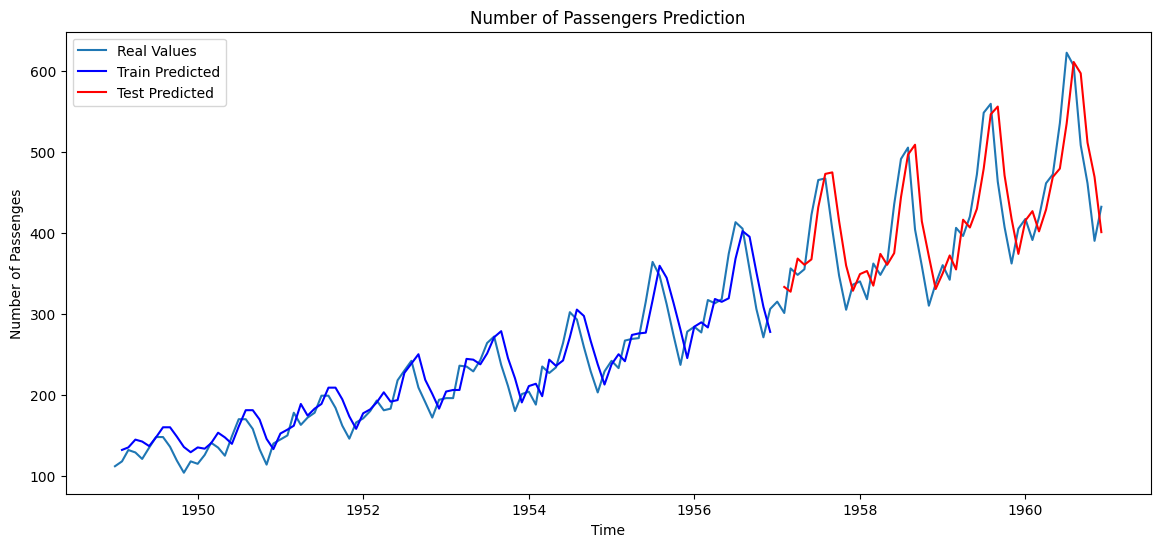

In [121]:
plt.figure(figsize=(14,6))
plt.plot(result_df, label= 'Real Values')
plt.plot(train_prediction_df["Predicted"], color='blue', label='Train Predicted')
plt.plot(test_pred_df["Predicted"], color="red", label="Test Predicted")
plt.title("Number of Passengers Prediction")
plt.xlabel('Time')
plt.ylabel('Number of Passenges')
plt.legend()
plt.show()